In [50]:
import tensorflow as tf
from tensorflow.keras.layers import Layer, Conv2D, MaxPooling2D, Dropout, Dense, Input, concatenate, GlobalAveragePooling2D, AveragePooling2D, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import fashion_mnist  
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import SGD, Adam, RMSprop
from tensorflow.keras.callbacks import LearningRateScheduler
import cv2
import numpy as np
import math
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model
import requests
from PIL import Image
from io import BytesIO
import os
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

In [51]:
# Caminho para o diretório do dataset
dataset_path = '/kaggle/input/fashionmnist'

# Listar o conteúdo do diretório
file_list = os.listdir(dataset_path)
print(file_list)

['t10k-labels-idx1-ubyte', 't10k-images-idx3-ubyte', 'fashion-mnist_test.csv', 'fashion-mnist_train.csv', 'train-labels-idx1-ubyte', 'train-images-idx3-ubyte']


In [52]:
# Função para carregar e processar os dados
def load_fashion_mnist(img_rows, img_cols):
    (X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()
    
    # Redimensionar e normalizar os dados
    X_train_resized = np.array([cv2.resize(image, (img_rows, img_cols)) for image in X_train])
    X_test_resized = np.array([cv2.resize(image, (img_rows, img_cols)) for image in X_test])

    # Adiciona a dimensão do canal de cor (1 para imagens em escala de cinza)
    X_train_resized = X_train_resized.reshape(X_train_resized.shape[0], img_rows, img_cols, 1).astype('float32') / 255.0
    X_test_resized = X_test_resized.reshape(X_test_resized.shape[0], img_rows, img_cols, 1).astype('float32') / 255.0

    # Dividir os dados de treino em conjuntos de treino e validação
    X_train, X_valid, y_train, y_valid = train_test_split(X_train_resized, y_train, test_size=0.2, stratify=y_train, random_state=42)
    
    # Converter os rótulos para o formato categórico
    num_classes = 10
    y_train = to_categorical(y_train, num_classes)
    y_valid = to_categorical(y_valid, num_classes)
    y_test = to_categorical(y_test, num_classes)

    return X_train, y_train, X_valid, y_valid, X_test_resized, y_test

In [53]:
# Carrega e pré-processa os dados do Fashion MNIST, alterando o tamanho da imagem para 32x32 pixels
img_rows, img_cols = 32, 32
X_train, y_train, X_valid, y_valid, X_test, y_test = load_fashion_mnist(img_rows, img_cols)

In [54]:
# Inicializadores de kernel (pesos iniciais) e bias
kernel_init = tf.keras.initializers.GlorotUniform()
bias_init = tf.keras.initializers.Constant(value=0.2)

In [55]:
# Função para criar um módulo de Inception
def inception_module(x, filters_1x1, filters_3x3_reduce, filters_3x3, filters_5x5_reduce, filters_5x5, filters_pool_proj, name=None):
    conv_1x1 = Conv2D(filters_1x1, (1, 1), padding='same', activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init)(x)

    conv_3x3 = Conv2D(filters_3x3_reduce, (1, 1), padding='same', activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init)(x)
    conv_3x3 = Conv2D(filters_3x3, (3, 3), padding='same', activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init)(conv_3x3)

    conv_5x5 = Conv2D(filters_5x5_reduce, (1, 1), padding='same', activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init)(x)
    conv_5x5 = Conv2D(filters_5x5, (5, 5), padding='same', activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init)(conv_5x5)

    pool_proj = MaxPooling2D((3, 3), strides=(1, 1), padding='same')(x)
    pool_proj = Conv2D(filters_pool_proj, (1, 1), padding='same', activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init)(pool_proj)

    output = concatenate([conv_1x1, conv_3x3, conv_5x5, pool_proj], axis=3, name=name)
    return output

In [56]:
# Modelo principal
input_layer = Input(shape=(32, 32, 1))

In [57]:
# Primeira camada convolucional
x = Conv2D(64, (7, 7), padding='same', strides=(2, 2), activation='relu')(input_layer)

In [58]:
# Primeira camada de Max Pooling
x = MaxPooling2D((3, 3), padding='same', strides=(2, 2))(x)

In [59]:
# Segunda camada convolucional (1x1)
x = Conv2D(64, (1, 1), padding='same', activation='relu')(x)

In [60]:
# Terceira camada convolucional (3x3)
x = Conv2D(192, (3, 3), padding='same', activation='relu')(x)

In [61]:
# Segunda Camada de Max Pooling
x = MaxPooling2D((3, 3), padding='same', strides=(2, 2))(x)

In [62]:
x = inception_module(x, filters_1x1=64, filters_3x3_reduce=96, filters_3x3=128, filters_5x5_reduce=16, filters_5x5=32, filters_pool_proj=32)
x = inception_module(x, filters_1x1=128, filters_3x3_reduce=128, filters_3x3=192, filters_5x5_reduce=32, filters_5x5=96, filters_pool_proj=64)

In [63]:
# Terceira camada de Max Pooling
x = MaxPooling2D((3, 3), padding='same', strides=(2, 2))(x)

In [64]:
# Camada Auxiliar
x1 = AveragePooling2D((3, 3), strides=2, padding='same')(x)
x1 = Conv2D(128, (1, 1), padding='same', activation='relu')(x1)
x1 = Flatten()(x1)
x1 = Dense(2048, activation='relu')(x1)
x1 = Dropout(0.2)(x1)
x1 = Dense(10, activation='softmax', name='auxiliary_output_1')(x1)

In [65]:
# Mais Módulos Inception
x = inception_module(x, filters_1x1=256, filters_3x3_reduce=160, filters_3x3=320, filters_5x5_reduce=32, filters_5x5=128, filters_pool_proj=128)
x = inception_module(x, filters_1x1=384, filters_3x3_reduce=192, filters_3x3=384, filters_5x5_reduce=48, filters_5x5=128, filters_pool_proj=128)

In [66]:
# Global average pooling
x = GlobalAveragePooling2D()(x)

In [67]:
# Dropout
x = Dropout(0.5)(x)

In [68]:
# Dense
x = Dense(10, activation='softmax', name='output')(x)

In [69]:
# Cria o modelo final com as saídas principais e auxiliares
model = Model(input_layer, [x, x1], name='inception_v1')

In [70]:
# Resumo da arquitetura do modelo
model.summary()

Model: "inception_v1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 32, 32, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_25 (Conv2D)  │ (None, 16, 16,    │      3,200 │ input_layer_1[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_6     │ (None, 8, 8, 64)  │          0 │ conv2d_25[0][0]   │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_26 (Conv2D)  │ (None, 8, 8, 64)  │      4,160 │ max_pooling2d_6[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_27 (Conv2D)  │ (None, 8, 8, 192) │    110,784 │ conv2d_26[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_7     │ (None, 4, 4, 192) │          0 │ conv2d_27[0][0]   │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_29 (Conv2D)  │ (None, 4, 4, 96)  │     18,528 │ max_pooling2d_7[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_31 (Conv2D)  │ (None, 4, 4, 16)  │      3,088 │ max_pooling2d_7[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_8     │ (None, 4, 4, 192) │          0 │ max_pooling2d_7[… │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_28 (Conv2D)  │ (None, 4, 4, 64)  │     12,352 │ max_pooling2d_7[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_30 (Conv2D)  │ (None, 4, 4, 128) │    110,720 │ conv2d_29[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_32 (Conv2D)  │ (None, 4, 4, 32)  │     12,832 │ conv2d_31[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_33 (Conv2D)  │ (None, 4, 4, 32)  │      6,176 │ max_pooling2d_8[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_4       │ (None, 4, 4, 256) │          0 │ conv2d_28[0][0],  │
│ (Concatenate)       │                   │            │ conv2d_30[0][0],  │
│                     │                   │            │ conv2d_32[0][0],  │
│                     │                   │            │ conv2d_33[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_35 (Conv2D)  │ (None, 4, 4, 128) │     32,896 │ concatenate_4[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_37 (Conv2D)  │ (None, 4, 4, 32)  │      8,224 │ concatenate_4[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_9     │ (None, 4, 4, 256) │          0 │ concatenate_4[0]… │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_34 (Conv2D)  │ (None, 4, 4, 128) │     32,896 │ concatenate_4[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_36 (Conv2D)  │ (None, 4, 4, 192) │    221,376 │ conv2d_35[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_38 (Conv2D)  │ (None, 4, 4, 96)  │     76,896 │ conv2d_37[0][0]   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 3,311,860 (12.63 MB)

 Trainable params: 3,311,860 (12.63 MB)

 Non-trainable params: 0 (0.00 B)

In [71]:
# Parâmetros de treinamento
epochs = 100
initial_lrate = 0.01

In [72]:
# Função de decaimento da taxa de aprendizado
def decay(epoch):
    drop = 0.96
    epochs_drop = 5
    lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
    return lrate

In [73]:
#  implementação com Adam
optim = Adam(learning_rate=initial_lrate)

In [74]:
lr_sc = LearningRateScheduler(decay, verbose=1)

In [75]:
model.compile(
    loss=['categorical_crossentropy', 'categorical_crossentropy'],
    loss_weights=[1, 0.3],
    optimizer=optim,
    metrics=[['accuracy'], ['accuracy']]
)

In [76]:
with tf.device('/gpu:0'):
    model.fit(X_train, [y_train, y_train], validation_data=(X_test, [y_test, y_test]), epochs=epochs, batch_size=512, callbacks=[lr_sc])


Epoch 1: LearningRateScheduler setting learning rate to 0.01.
Epoch 1/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 147s 1s/step - auxiliary_output_1_accuracy: 0.2496 - loss: 30.0256 - output_accuracy: 0.2360 - val_auxiliary_output_1_accuracy: 0.6864 - val_loss: 0.9726 - val_output_accuracy: 0.7229 - learning_rate: 0.0100

Epoch 2: LearningRateScheduler setting learning rate to 0.01.
Epoch 2/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 136s 1s/step - auxiliary_output_1_accuracy: 0.7245 - loss: 0.9032 - output_accuracy: 0.7412 - val_auxiliary_output_1_accuracy: 0.7752 - val_loss: 0.7244 - val_output_accuracy: 0.7916 - learning_rate: 0.0100

Epoch 3: LearningRateScheduler setting learning rate to 0.01.
Epoch 3/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 136s 1s/step - auxiliary_output_1_accuracy: 0.7955 - loss: 0.6981 - output_accuracy: 0.8046 - val_auxiliary_output_1_accuracy: 0.7966 - val_loss: 0.6610 - val_output_accuracy: 0.8026 - learning_rate: 0.0100

Epoch 4: LearningRateScheduler setting learning rate to 0.01.
Epoch 4/1

In [78]:
# Salvamento do modelo treinado
model.save('my_saved_model.keras')

In [79]:
# Gera previsões
predictions = model.predict(X_test)

# Separa as previsões principais e auxiliares
main_predictions, aux1_predictions = predictions

# Verifica a classe prevista e a classe verdadeira para o primeiro exemplo do conjunto de teste
predicted_classes = np.argmax(main_predictions, axis=1)
true_classes = np.argmax(y_test, axis=1)

print(f"Predicted first example class: {predicted_classes[0]}")
print(f"True first example class: {true_classes[0]}")

313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step
Predicted first example class: 9
True first example class: 9


In [80]:
# Visualizar predições erradas
class_names = ['T-shirt','Trouser','Pullover','Dress','Coat','Sandal','Shirt','Sneaker','Bag', 'Ankle boot' ]

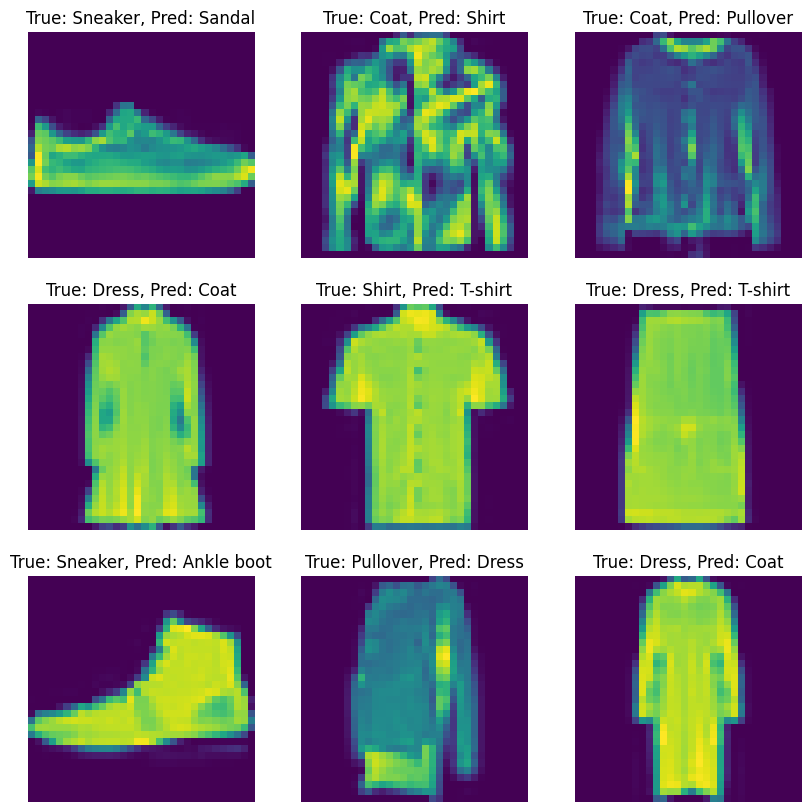

In [84]:
# Função para visualizar previsões incorretas
def plot_misclassified_images(images, true_labels, predicted_labels, class_names):
    misclassified = true_labels != predicted_labels
    misclassified_images = images[misclassified]
    true_labels = true_labels[misclassified]
    predicted_labels = predicted_labels[misclassified]

    plt.figure(figsize=(10, 10))
    for i in range(min(9, len(misclassified_images))):  # plota até 9 imagens incorretas ou menos se houver menos de 9
        plt.subplot(3, 3, i + 1)
        plt.imshow(misclassified_images[i])
        true_class_name = class_names[true_labels[i]]
        predicted_class_name = class_names[predicted_labels[i]]
        plt.title(f"True: {true_class_name}, Pred: {predicted_class_name}")
        plt.axis("off")
    plt.show()

# Exemplo de uso
# true_classes e predicted_classes são arrays com os índices das classes verdadeiras e previstas, respectivamente
# X_test são as imagens de teste
plot_misclassified_images(X_test, true_classes, predicted_classes, class_names)